In [2]:
pip install -q -U watermark

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -qq transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.4
IPython 7.8.0

numpy 1.16.5
pandas 0.25.1
torch 1.2.0+cu92
transformers 2.9.1


In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
df = pd.read_csv("reviews.csv")
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOF35q4r3ONpFjdnmnPUTw7geO7-hYgDHnQS344...,Kelly Powers,https://lh3.googleusercontent.com/a-/AOh14GjXC...,Loved the app and service at first despite the...,1,21,12.6.3,2020-05-12 23:41:35,NaN,NaN,most_relevant,com.dd.doordash
1,gp:AOqpTOFvdq_l0kLudGhRs1A8X3aiz19HX_3AI3MgIVh...,HoneyDew *,https://lh3.googleusercontent.com/a-/AOh14Gjrp...,Don't waste your money!! Customer service was ...,1,10,12.6.2,2020-05-13 09:49:38,NaN,NaN,most_relevant,com.dd.doordash
2,gp:AOqpTOHRkC7z1DfVv1EDejp63hESEmryNeZaJE9Mwyi...,XMs_ MorgueX,https://lh3.googleusercontent.com/-fisSzZs5lFo...,"At first, this was a great app. Your food came...",1,307,12.5.3,2020-05-04 16:55:26,NaN,NaN,most_relevant,com.dd.doordash
3,gp:AOqpTOHFy1gFcXRdVtM6SDfoIKy58aLiawSvVA19Vxt...,Dan Hammond,https://lh3.googleusercontent.com/a-/AOh14GjEY...,This app is SOOOO slow compared to all other a...,1,0,12.6.3,2020-05-12 23:40:34,NaN,NaN,most_relevant,com.dd.doordash
4,gp:AOqpTOF9hsURyAMTxPPIwn2-wiZ9w-1dKX0t39NWxUj...,Mickey Louse,https://lh3.googleusercontent.com/a-/AOh14GhQv...,Impossible to create a new account. It keeps r...,1,259,12.5.3,2020-04-26 01:34:34,NaN,NaN,most_relevant,com.dd.doordash


In [7]:
df.shape

(14400, 12)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14400 entries, 0 to 14399
Data columns (total 12 columns):
reviewId                14400 non-null object
userName                14400 non-null object
userImage               14400 non-null object
content                 14400 non-null object
score                   14400 non-null int64
thumbsUpCount           14400 non-null int64
reviewCreatedVersion    13578 non-null object
at                      14400 non-null object
replyContent            2604 non-null object
repliedAt               2604 non-null object
sortOrder               14400 non-null object
appId                   14400 non-null object
dtypes: int64(2), object(10)
memory usage: 1.3+ MB


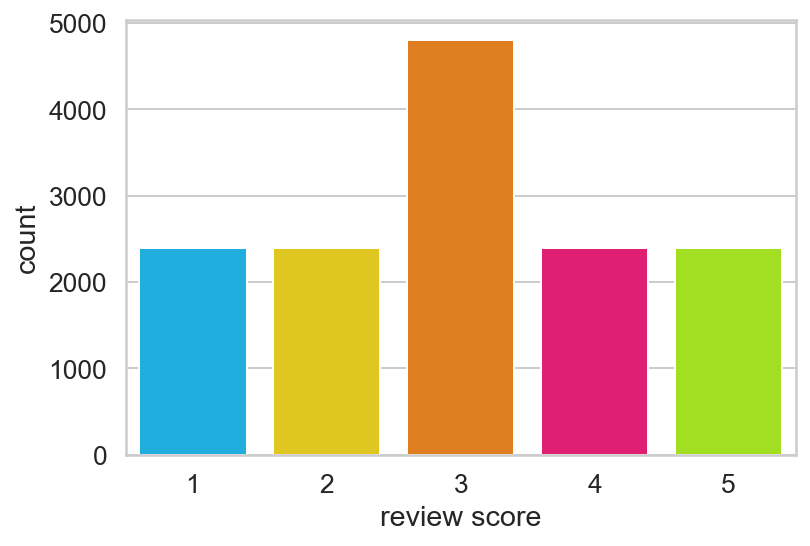

In [9]:
sns.countplot(df.score)
plt.xlabel('review score');

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative', 'neutral', 'positive']

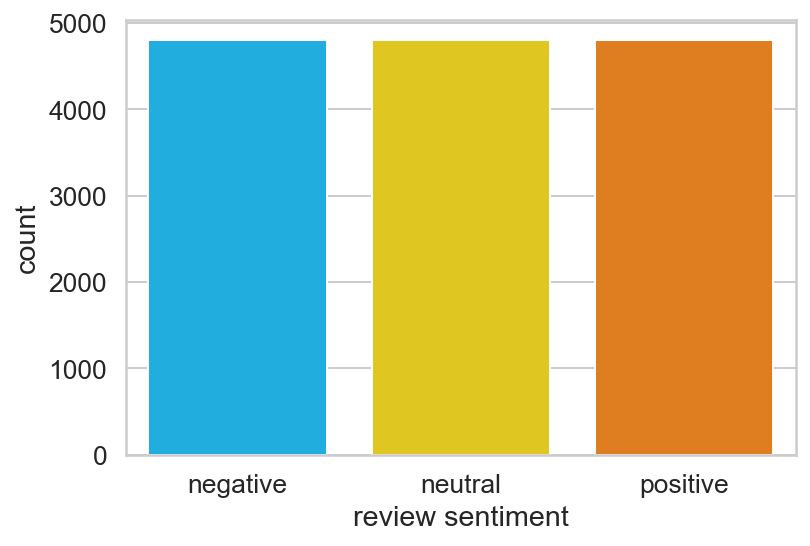

In [12]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [13]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [16]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [17]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [19]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [20]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [22]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [25]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

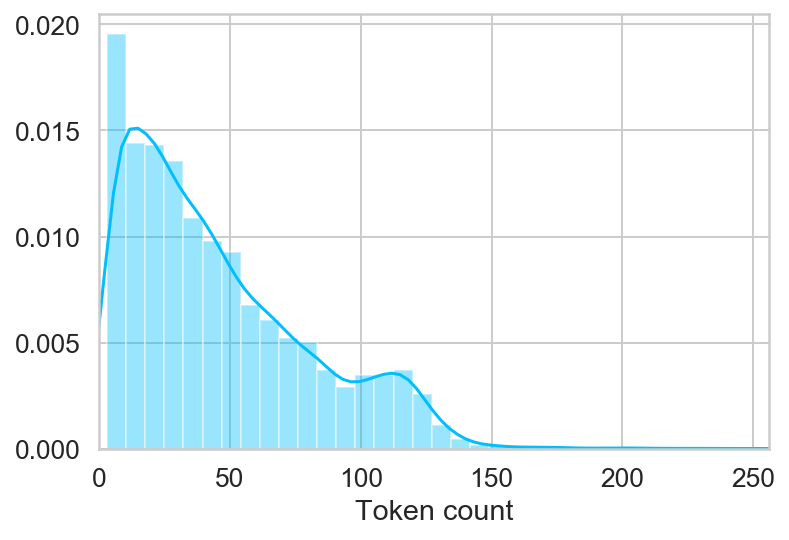

In [26]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [27]:
MAX_LEN = 160

In [28]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [29]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((12960, 13), (720, 13), (720, 13))

In [82]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
      num_workers=0
  )

In [83]:
BATCH_SIZE = 10

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [84]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [85]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([10, 160])
torch.Size([10, 160])
torch.Size([10])


In [86]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [87]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [88]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [89]:
bert_model.config.hidden_size

768

In [90]:
pooled_output.shape

torch.Size([1, 768])

In [91]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [92]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [93]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([10, 160])
torch.Size([10, 160])


In [94]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5732, 0.3196, 0.1072],
        [0.6177, 0.2512, 0.1312],
        [0.7152, 0.2179, 0.0669],
        [0.6698, 0.2310, 0.0992],
        [0.6684, 0.2620, 0.0696],
        [0.6253, 0.2939, 0.0808],
        [0.7189, 0.1716, 0.1096],
        [0.7003, 0.2056, 0.0941],
        [0.6414, 0.2578, 0.1008],
        [0.6203, 0.2384, 0.1413]], grad_fn=<SoftmaxBackward>)

In [95]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [96]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [97]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
